In [1]:
!pip install qutip
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from qutip.qip.circuit import QubitCircuit, Gate

# Generation of spin-photon entangled pair via Humsphrey's protocol


Based on the spin-photon entanglement result, we would like to develope the protocol to entangle the two spin systems with high fidelity. To start with, let's prepare two copies of spin-photon systems. In Humsphrey's protocol (Nature 558, 268 (2018)), we prepare the two spin-cavity systems with initial state $$|\psi_0\rangle=\left(\sqrt{\alpha}|g_{\downarrow}0\rangle_A+\sqrt{1-\alpha}|g_{\uparrow}0\rangle_A\right)\otimes\left(\sqrt{\alpha}|g_{\downarrow}0\rangle_B+\sqrt{1-\alpha}|g_{\uparrow}0\rangle_B\right)$$, where $|g_{\downarrow}\rangle$ ($|g_{\uparrow}\rangle$) denotes the bright (dark) state and $|0\rangle$ denotes the vacuum state of the cavity mode. Afterwards, we send the resonant optical field, whose Rabi frequency is $\Omega_s$,  to the frequency between the transition $|g_\downarrow\rangle_{s}\rightarrow|e\rangle_{s}$, to the NV system, where $s=A,B$. The interaction Hamiltonian can be written as: $$\hat{H}/\hbar=\sum_{s=A,B}\Omega_s\hat{a}_s\hat{\sigma}_{+,s}+\text{h.c.}$$
, where $\hat{\sigma}_{+,s}=|e\rangle_{ss}\langle g_{\downarrow}|$, with the excitation time-dependent Hamiltonian that uses the semi-classical approximation: $$\hat{H}_{\text{exc}}\left(t\right)/\hbar=\sum_{s=A,B}P_s\left(t\right)\hat{\sigma}_{+,s}+\text{h.c.}$$
, where $P_s\left(t\right)$ is the Rabi frequency of the excitation pulse. For simplicity, let's assume identical Rabi frequencies, excitation pulses of system A and B as $\Omega$ and $P\left(t\right)$. Subsequently, we count the clicks that occur at detector $D_1$ or $D_2$. As a reminder, $D_1$ (or $D_2$) stands for the collapsing operator of mode $\hat{a}_A+\hat{a}_B$ (or $\hat{a}_A-\hat{a}_B$).

In the following, we provide the codes to simulate the overall process.

In [2]:
Na = 3 # number of atomic levels
ground_down = basis(Na, 0)
ground_up = basis(Na, 1)
excited = basis(Na, 2)

# Here, let's choose the basis of state as |photon_A, spin_A, photon_B, spin_B>

N = 5 # Set where to truncate Fock state of cavity
sigma_A_gd_e = tensor(qeye(N), ground_down * excited.dag(), qeye(N), qeye(Na)) # |g_down><e| of system A
sigma_B_gd_e = tensor(qeye(N), qeye(Na), qeye(N), ground_down * excited.dag()) # |g_down><e| of system B

a_A = tensor(destroy(N), qeye(Na), qeye(N), qeye(Na)) # annihiliation occurs of system A
a_B = tensor(qeye(N), qeye(Na), destroy(N), qeye(Na)) # annihiliation occurs of system B

### Let's define collapse operators
c_ops = [] # Build collapse operators

kappa =0.1 # Cavity decay rate
c_ops.append(np.sqrt(kappa) * a_A) # Cavity decay of system A. C0
c_ops.append(np.sqrt(kappa) * a_B) # Cavity decay of system B. C1

gamma =1 # Atomic decay rate
c_ops.append(np.sqrt(gamma) * sigma_A_gd_e) # spontaneous decay (decaying to modes other than cavity) from |e> to |g_down> of system A.   C2
c_ops.append(np.sqrt(gamma) * sigma_B_gd_e) # spontaneous decay (decaying to modes other than cavity) from |e> to |g_down> of system B.   C3

K_c =20 # rate for collapsing to detector
c_ops.append(np.sqrt(K_c) * (a_A+a_B)/np.sqrt(2)) # Collapsing to detector 1        C4
c_ops.append(np.sqrt(K_c) * (a_A-a_B)/np.sqrt(2)) # Collapsing to detector 2        C5

time_scale=400
t = np.linspace(0.0, 5.0, time_scale) # Define time vector


# Step 1
theta=np.pi/2*0.885
photon = basis(N, 0) # Initial photonic state
spin = ground_down*np.cos(theta)+ground_up*np.sin(theta) # Initial spin state
psi0 = tensor(photon, spin, photon, spin) # Initial global state


g0 = 2 # coupling strength (Rabi frequency of vacuum field)
# Here describes the interaction Hamiltonian
H0_A = -g0 * (sigma_A_gd_e.dag() * a_A+a_A.dag()* sigma_A_gd_e) # time-independent Hamiltonian of system A
H0_B = -g0 * (sigma_B_gd_e.dag() * a_B+a_B.dag()* sigma_B_gd_e) # time-independent Hamiltonian of system B
H0 = H0_A + H0_B # time-independent Hermitian of global system

# Here describes the excitation Hamiltonian
H1_A = (sigma_A_gd_e.dag() + sigma_A_gd_e) # time-dependent Hamiltonian of system A after semi-classical approximation
H1_B = (sigma_B_gd_e.dag() + sigma_B_gd_e) # time-dependent Hamiltonian of system A after semi-classical approximation

numb=2000 # numbers of trajectories
ntraj=[numb]

# Excitation pulse parameters
center=0.5
life_time=0.04
peak =np.sqrt(np.pi)/2/life_time
excite_pulse = peak * np.exp(-((t-center) / life_time) ** 2)


# Step 2
H = [H0,[H1_A, excite_pulse],[H1_B, excite_pulse]]
output = mcsolve(H, psi0, t, c_ops, [], ntraj, progress_bar=False)

Given that fiedlity has different trend as success probability, we ought to make trade off between them. Utilizing BK protocol to boost the entanglement fidelity to be $99.5\%$ with success probability $\sim2.5\%$, we examine the success probability in acheiving the same fidelity with Humsphrey protocol.

In [3]:
C4=[]
C5=[]

# In this section, we select the events that detector 1 or detector 2 fires (C4 or C5 occurs)
for i in range(numb):
    for j in range(len(output.col_which[i])):
        if output.col_which[i][j]==4:
            C4.append(i) # detector 1 fires
        if output.col_which[i][j]==5:
            C5.append(i) # detector 2 fires

C4=np.unique(C4) # we get rid of double collapsing in detector 1 of each trajectory
C5=np.unique(C5) # we get rid of double collapsing in detector 2 of each trajectory

rho_C4=0*output.states[0][0].ptrace([1,3])
for n in C4:
    rho_C4+=output.states[n][time_scale-1].ptrace([1,3]) # We trace out all photonic modes and leave only the spin degrees of freedome
rho_C4=rho_C4/len(C4) # taking the ensemble average of those states that detector 1 fires

rho_C5=0*output.states[0][0].ptrace([1,3])
for n in C5:
    rho_C5+=output.states[n][time_scale-1].ptrace([1,3]) # We trace out all photonic modes and leave only the spin degrees of freedome
rho_C5=rho_C5/len(C5) # taking the ensemble average of those states that detector 2 fires


# We expect the spin state that detector 1 (2) fires will result in a bell state |01>+|10> (|01>-|10>) and let's calculate the entanglement entropy as well as their fiedlities
Bell1=tensor(ground_down,ground_up)/np.sqrt(2)+tensor(ground_up,ground_down)/np.sqrt(2)
print("The entanglement entropy that D1 fires: ",(entropy_vn(rho_C4.ptrace(0),2)+entropy_vn(rho_C4.ptrace(1),2))/2, " with fidelity:",fidelity(rho_C4,Bell1)," and success probability ",len(C4)/numb)

Bell2=tensor(ground_down,ground_up)/np.sqrt(2)-tensor(ground_up,ground_down)/np.sqrt(2)
print("The entanglement entropy that D2 fires: ",(entropy_vn(rho_C5.ptrace(0),2)+entropy_vn(rho_C5.ptrace(1),2))/2, " with fidelity:",fidelity(rho_C5,Bell2)," and success probability ",len(C5)/numb)

The entanglement entropy that D1 fires:  0.9999822849073828  with fidelity: 0.9999855495999325  and success probability  0.0135
The entanglement entropy that D2 fires:  0.9991452049496758  with fidelity: 0.9826033826067548  and success probability  0.0145


Apparently, the success probabiltiy of Humsphrey's scheme is $\sim1.4\%$, which is less than the outcome of BK scheme.

In the following codes, we sweep the values of $\alpha$ and examine the entanglement fidelities and the corresponding success probabilities.

In [ ]:
Na = 3 # number of atomic levels
ground_down = basis(Na, 0)
ground_up = basis(Na, 1)
excited = basis(Na, 2)

# Here, let's choose the basis of state as |photon_A, spin_A, photon_B, spin_B>

N = 4 # Set where to truncate Fock state of cavity
sigma_A_gd_e = tensor(qeye(N), ground_down * excited.dag(), qeye(N), qeye(Na)) # |g_down><e| of system A
sigma_B_gd_e = tensor(qeye(N), qeye(Na), qeye(N), ground_down * excited.dag()) # |g_down><e| of system B

a_A = tensor(destroy(N), qeye(Na), qeye(N), qeye(Na)) # annihiliation occurs of system A
a_B = tensor(qeye(N), qeye(Na), destroy(N), qeye(Na)) # annihiliation occurs of system B

### Let's define collapse operators
c_ops = [] # Build collapse operators

kappa =0.1 # Cavity decay rate
c_ops.append(np.sqrt(kappa) * a_A) # Cavity decay of system A. C0
c_ops.append(np.sqrt(kappa) * a_B) # Cavity decay of system B. C1

gamma =1 # Atomic decay rate
c_ops.append(np.sqrt(gamma) * sigma_A_gd_e) # spontaneous decay (decaying to modes other than cavity) from |e> to |g_down> of system A.   C2
c_ops.append(np.sqrt(gamma) * sigma_B_gd_e) # spontaneous decay (decaying to modes other than cavity) from |e> to |g_down> of system B.   C3

K_c =20 # rate for collapsing to detector
c_ops.append(np.sqrt(K_c) * (a_A+a_B)/np.sqrt(2)) # Collapsing to detector 1        C4
c_ops.append(np.sqrt(K_c) * (a_A-a_B)/np.sqrt(2)) # Collapsing to detector 2        C5

time_scale=200
t = np.linspace(0.0, 2.0, time_scale) # Define time vector


g0 = 2 # coupling strength (Rabi frequency of vacuum field)
# Here describes the interaction Hamiltonian
H0_A = -g0 * (sigma_A_gd_e.dag() * a_A+a_A.dag()* sigma_A_gd_e) # time-independent Hamiltonian of system A
H0_B = -g0 * (sigma_B_gd_e.dag() * a_B+a_B.dag()* sigma_B_gd_e) # time-independent Hamiltonian of system B
H0 = H0_A + H0_B # time-independent Hermitian of global system

# Here describes the excitation Hamiltonian
H1_A = (sigma_A_gd_e.dag() + sigma_A_gd_e) # time-dependent Hamiltonian of system A after semi-classical approximation
H1_B = (sigma_B_gd_e.dag() + sigma_B_gd_e) # time-dependent Hamiltonian of system A after semi-classical approximation

numb=1200 # numbers of trajectories
ntraj=[numb]

# Excitation pulse parameters
center=0.5
life_time=0.04
peak =np.sqrt(np.pi)/2/life_time
excite_pulse = peak * np.exp(-((t-center) / life_time) ** 2)


scale=20
theta = np.linspace(0,np.pi/2*0.94,scale)
photon_0 = basis(N, 0) # Initial photonic state in system A is in vacuum

Bell1=tensor(ground_down,ground_up)/np.sqrt(2)+tensor(ground_up,ground_down)/np.sqrt(2)
Bell2=tensor(ground_down,ground_up)/np.sqrt(2)-tensor(ground_up,ground_down)/np.sqrt(2)


alpha = np.cos(theta)**2

fid_C4 = np.zeros(scale)
succ_prob_C4 = np.zeros(scale)
fid_C5 = np.zeros(scale)
succ_prob_C5 = np.zeros(scale)

for idx, angle in enumerate(theta):
    spin_0 = ground_down*np.cos(angle)+ground_up*np.sin(angle) # Initial spin state in system A as the superposition state of |g_down> and |g_up>
    psi0 = tensor(photon_0, spin_0, photon_0, spin_0) # Initial global state
    H = [H0,[H1_A, excite_pulse],[H1_B, excite_pulse]]
    output = mcsolve(H, psi0, t, c_ops, [], ntraj, progress_bar=False)
    C4=[]
    C5=[]
    # In this section, we select the events that detector 1 or detector 2 fires (C4 or C5 occurs)
    for i in range(numb):
        for j in range(len(output.col_which[i])):
            if output.col_which[i][j]==4:
                C4.append(i) # detector 1 fires
            if output.col_which[i][j]==5:
                C5.append(i) # detector 2 fires

    C4=np.unique(C4) # we get rid of double collapsing in detector 1 of each trajectory
    C5=np.unique(C5) # we get rid of double collapsing in detector 1 of each trajectory

    succ_prob_C4[idx]=len(C4)/numb
    succ_prob_C5[idx]=len(C5)/numb

    rho_C4=0*output.states[0][0].ptrace([1,3])
    for n in C4:
        rho_C4+=output.states[n][time_scale-1].ptrace([1,3]) # We trace out all photonic modes and leave only the spin degrees of freedome
    rho_C4=rho_C4/len(C4) # taking the ensemble average of those states that detector 1 fires
    fid_C4[idx]=fidelity(rho_C4,Bell1)

    rho_C5=0*output.states[0][0].ptrace([1,3])
    for n in C5:
        rho_C5+=output.states[n][time_scale-1].ptrace([1,3]) # We trace out all photonic modes and leave only the spin degrees of freedome
    rho_C5=rho_C5/len(C5) # taking the ensemble average of those states that detector 1 fires
    fid_C5[idx]=fidelity(rho_C5,Bell2)

# Target state: $|g_{\downarrow}g_{\uparrow}\rangle+|g_{\uparrow}g_{\downarrow}\rangle$

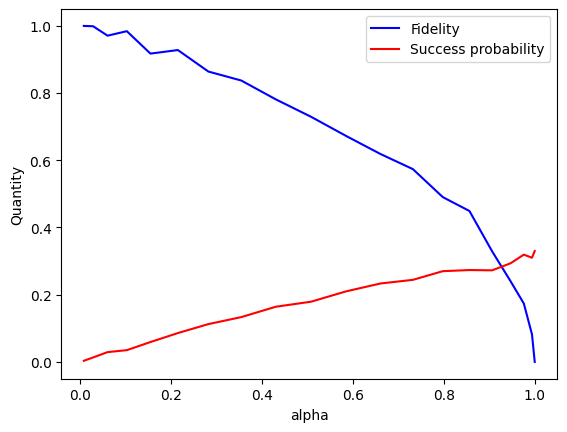

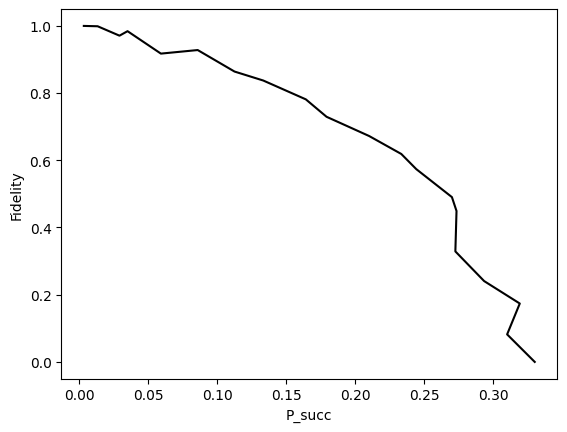

In [ ]:
plt.plot(alpha,fid_C4, "b",label='Fidelity')
plt.plot(alpha,succ_prob_C4, "r",label='Success probability')
plt.xlabel('alpha')
plt.ylabel('Quantity')
plt.legend()
plt.show()
plt.plot(succ_prob_C4,fid_C4, "k")
plt.xlabel('P_succ')
plt.ylabel('Fidelity')
plt.show()

# Target state: $|g_{\downarrow}g_{\uparrow}\rangle-|g_{\uparrow}g_{\downarrow}\rangle$

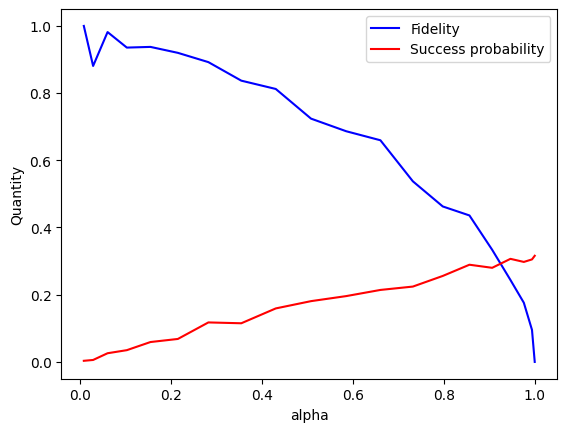

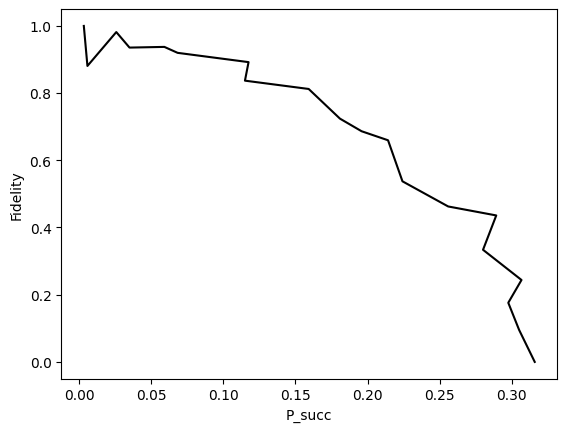

In [ ]:
plt.plot(alpha,fid_C5, "b",label='Fidelity')
plt.plot(alpha,succ_prob_C5, "r",label='Success probability')
plt.xlabel('alpha')
plt.ylabel('Quantity')
plt.legend()
plt.show()
plt.plot(succ_prob_C5,fid_C5, "k")
plt.xlabel('P_succ')
plt.ylabel('Fidelity')
plt.show()